# Final Project Part I

In this final project, you will work through the Database Design, ETL and Analytics phases using a multii-year Chicago crime data source. This final project is divided into two parts.  Part I fill focus on the database design and ETL.  Part II will focus on the analytics.

In this Part I you will conduct the following tasks:

1. Reverse engineer an existing sourse RDBMS using metadata SQL queries to identify the table and attribute details necessary for creating tables and an entity-relationship diagram depecting the database logical structure. The source data is an SQLite database.
2. Implement a set of tables using DDL in your SSO dsa_student database schema on the postgres server that replicates the source database structure.
3. Create an Entity Relationship Diagram.
4. Establish connections to the source and destination databases.
5. Extract the source data from tables, Transform values as required and Load into the destination tables.
6. Validate the ETL process by confirming row counts in both source and destination tables.


Specific resourses and steps are listed below:

## Source SQLite Database

* Dataset URL: **/dsa/data/DSA-7030/cc0122dbv2.sqlite.db**
* Data Dictionary: [pdf](./ChicagoData-Description.pdf)
* [Chicago Crimes 2001-Present Dashboard](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present-Dashboard/5cd6-ry5g)

This SQLite database consists of a set of normalized relations populated with publically available Chicago crime data for the years 2001 to 2022.  

## Database exploration

The cells below provide SQL DML statments for examining the underlying metadata in the SQLite database that describes the table, column, and relationship details.  An initial connection and subsequent SQL statements are provided for acquiring the information necessary for reconstructing the table and relational structure in your postgres SSO database.

In [1]:
#Load extention and connect to database
%load_ext sql
%sql sqlite:////dsa/data/DSA-7030/cc0122dbv2.sqlite.db
    

'Connected: @/dsa/data/DSA-7030/cc0122dbv2.sqlite.db'

In [12]:
####################

%%sql 

SELECT sql FROM sqlite_schema WHERE name = 'cc_iucr_codes' ;



SyntaxError: invalid syntax (<ipython-input-12-2e3e21ff14a3>, line 5)

## Explore the SQLite Tables List

This quiery simply lists the names of the database tables.

In [38]:
%%sql
SELECT distinct m.type, m.tbl_name --m.sql
FROM sqlite_master AS m,
     pragma_table_info(m.name) AS t
WHERE m.type = 'table'
order by m.name, t.pk DESC

## Explore Column Details

The query below provdes the complete list of tables and their columns with important details.

* **tbl_name** = Name of the table
* **name** = column name
* **type** = declared data type
* **notnull** = indicates column declared as NOT NULL
* **pk** = indicates column is the primary key

In [39]:
%%sql 
SELECT m.tbl_name, t.* --m.sql
 FROM pragma_table_info(m.tbl_name) t, sqlite_master m WHERE m.type='table';

## Below query provdes the list of columns that are declared "unique" for referential integrity enforcement.

<u>Query Output Descriptions</u>
* **name** = the table name begining at the "cc_" -- cc_case_location is table name.
* **unique** = indicates the column is declared "unique"
* **origin** = indicates the columns is declared as primary key
* **name_1** = column name

In [40]:
%%sql 
select il.*,ii.* --,m.sql
    from sqlite_master m, 
    pragma_index_list( m.name ) as il,
    pragma_index_info(il.name) as ii

## Explore Relationship Details (get foreign key references)

The below query exracts the details describing the foreign key referenes bewtween tables.

* **from_table** = the name of the one-side table
* **from_column** = the name of the foreign key column in the one-side table
* **to_table** = the name of the many-side reference table
* **to_column** = the name of the foreign key column in the one-side reference table

These metadata can be translated to the necessary SQL statement to establish a relationship between tables:

```SQL
FOREIGN KEY (<from_column>) REFERENCES <to_table>(<to_column>)
```

In [41]:
%%sql
SELECT 
    m.name as from_table, f.'from' as from_column, f.'table' as to_table, f.'to' as to_column --, m.sql
FROM
    sqlite_master m
    JOIN pragma_foreign_key_list(m.name) f ON m.name != f."table"
WHERE m.type = 'table'
ORDER BY m.name
;

## Using the metadata from above:

## Implement the required CREATE TABLE statements for establishing the Chicago Crime Database in your SSO dsa_student database.  

The SQL statement takes this form:

```SQL
CREATE TABLE SSO.tbl_name (
 column_name_1 data_type <unqiue, not null>,
 column_name_N data_type <unqiue, not null>,
 PRIMARY KEY (<column_name>),
 <FOREIGN KEY (from_column_name) REFERENCES <SSO.to_table_name>(to_column_name)
 );
```

**The database tables and column names created in your SSO postgres server dsa_student database should be named exactly as they appear in the ```cc0122dbv2.sqlite.db``` SQLite database.**

Use as many cells as desired.

In [39]:
#sql create table statements

# Connect to your SSO database using sqlAlchmey connection and implement your database structure

In [14]:
#implement tables in SSO database

import psycopg2
import getpass


database = "dsa_student"
user     = input("Type username (pawprint) and hit enter: ")
password = getpass.getpass("Type password and hit enter: ")

connection = psycopg2.connect(database = database,
                              user     = user,
                              host     = 'pgsql.dsa.lan',
                              password = password)

Type username (pawprint) and hit enter: hc3ng
Type password and hit enter: ········


In [15]:
#1
with connection, connection.cursor() as cursor:
    cursor.execute(
        '''
            CREATE TABLE hc3ng.cc_iucr_codes(
            iucr_code varchar(10) UNIQUE, 
            iucr_index_code char,
            PRIMARY KEY (iucr_code)
            );
        '''
    )
    cursor.execute("SELECT COLUMN_NAME FROM information_schema.COLUMNS WHERE TABLE_NAME ='cc_iucr_codes' and TABLE_SCHEMA=\'%s\';" % user)
    results = cursor.fetchall()

print("Columns in table:")
for row in results:
    print(row)

Columns in table:
('iucr_code',)
('iucr_index_code',)


In [16]:
#2
with connection, connection.cursor() as cursor:
    cursor.execute(
        '''
            CREATE TABLE hc3ng.cc_nibrs_crimes_against(
            nibrs_crime_against varchar(20) UNIQUE, 
            PRIMARY KEY (nibrs_crime_against)
            );
        '''
    )
    cursor.execute("SELECT COLUMN_NAME FROM information_schema.COLUMNS WHERE TABLE_NAME ='cc_nibrs_crimes_against' and TABLE_SCHEMA=\'%s\';" % user)
    results = cursor.fetchall()

print("Columns in table:")
for row in results:
    print(row)


Columns in table:
('nibrs_crime_against',)


In [17]:
#3
with connection, connection.cursor() as cursor:
    cursor.execute(
        '''
            CREATE TABLE hc3ng.cc_nibrs_categories(
            nibrs_offense_code varchar(10) UNIQUE,  
            nibrs_offense_category_name varchar(50), 
            PRIMARY KEY (nibrs_offense_code)
            );
        '''
    )
    cursor.execute("SELECT COLUMN_NAME FROM information_schema.COLUMNS WHERE TABLE_NAME ='cc_nibrs_categories' and TABLE_SCHEMA=\'%s\';" % user)
    results = cursor.fetchall()

print("Columns in table:")
for row in results:
    print(row)


Columns in table:
('nibrs_offense_code',)
('nibrs_offense_category_name',)


In [18]:
#4
with connection, connection.cursor() as cursor:
    cursor.execute(
        '''
            CREATE TABLE hc3ng.cc_iucr_codes_primary_descriptions(
            iucr_code varchar(10) UNIQUE, 
            iucr_primary_desc varchar(100), 
            PRIMARY KEY (iucr_code),
            UNIQUE (iucr_code),
            FOREIGN KEY(iucr_code) REFERENCES cc_iucr_codes(iucr_code)
            );
        '''
    )
    cursor.execute("SELECT COLUMN_NAME FROM information_schema.COLUMNS WHERE TABLE_NAME ='cc_iucr_codes_primary_descriptions' and TABLE_SCHEMA=\'%s\';" % user)
    results = cursor.fetchall()

print("Columns in table:")
for row in results:
    print(row)

Columns in table:
('iucr_code',)
('iucr_primary_desc',)


In [19]:
#5
with connection, connection.cursor() as cursor:
    cursor.execute(
        '''
            CREATE TABLE hc3ng.cc_iucr_codes_secondary_descriptions(
            iucr_code varchar(10) UNIQUE, 
            iucr_secondary_desc varchar(100), 
            PRIMARY KEY (iucr_code),
            UNIQUE (iucr_code),
            FOREIGN KEY(iucr_code) REFERENCES cc_iucr_codes(iucr_code)
            );
        '''
    )
    cursor.execute("SELECT COLUMN_NAME FROM information_schema.COLUMNS WHERE TABLE_NAME ='cc_iucr_codes_secondary_descriptions' and TABLE_SCHEMA=\'%s\';" % user)
    results = cursor.fetchall()

print("Columns in table:")
for row in results:
    print(row)

Columns in table:
('iucr_code',)
('iucr_secondary_desc',)


In [20]:
#6
with connection, connection.cursor() as cursor:
    cursor.execute(
        '''
            CREATE TABLE hc3ng.cc_nibrs_fbicode_offenses(
            nibrs_offense_code varchar(10) UNIQUE, 
            nibrs_offense_name varchar(100),
            PRIMARY KEY (nibrs_offense_code),
            FOREIGN KEY (nibrs_offense_code) REFERENCES cc_nibrs_categories (nibrs_offense_code)
            );
        '''
    )
    cursor.execute("SELECT COLUMN_NAME FROM information_schema.COLUMNS WHERE TABLE_NAME ='cc_nibrs_fbicode_offenses' and TABLE_SCHEMA=\'%s\';" % user)
    results = cursor.fetchall()

print("Columns in table:")
for row in results:
    print(row)

Columns in table:
('nibrs_offense_code',)
('nibrs_offense_name',)


In [21]:
#7
with connection, connection.cursor() as cursor:
    cursor.execute(
        '''
            CREATE TABLE hc3ng.cc_nibrs_offenses_crimes_aginst(
            nibrs_crime_against varchar(20), 
            nibrs_offense_code varchar (10), 
            PRIMARY KEY (nibrs_crime_against, nibrs_offense_code), 
            FOREIGN KEY (nibrs_crime_against) REFERENCES cc_nibrs_crimes_against(nibrs_crime_against),
            FOREIGN KEY (nibrs_offense_code) REFERENCES cc_nibrs_fbicode_offenses(nibrs_offense_code)
            );           
        '''
    )
    cursor.execute("SELECT COLUMN_NAME FROM information_schema.COLUMNS WHERE TABLE_NAME ='cc_nibrs_offenses_crimes_aginst' and TABLE_SCHEMA=\'%s\';" % user)
    results = cursor.fetchall()

print("Columns in table:")
for row in results:
    print(row)

Columns in table:
('nibrs_crime_against',)
('nibrs_offense_code',)


In [37]:
#8
with connection, connection.cursor() as cursor:
    cursor.execute(
        '''
            CREATE TABLE hc3ng.cc_cases(
            case_number varchar(20) UNIQUE, 
            incident_date timestamp , 
            iucr_code varchar(10) , 
            nibrs_fbi_offense_code varchar (10), 
            arrest INT, 
            domestic INT, 
            updated_on timestamp, 
            PRIMARY KEY (case_number), 
            FOREIGN KEY (iucr_code) REFERENCES cc_iucr_codes (iucr_code), 
            FOREIGN KEY (nibrs_fbi_offense_code)REFERENCES cc_nibrs_fbicode_offenses (nibrs_offense_code),
            UNIQUE (case_number)
            );
        '''
    )
    cursor.execute("SELECT COLUMN_NAME FROM information_schema.COLUMNS WHERE TABLE_NAME ='cc_cases' and TABLE_SCHEMA=\'%s\';" % user)
    results = cursor.fetchall()

print("Columns in table:")
for row in results:
    print(row)

Columns in table:
('case_number',)
('incident_date',)
('iucr_code',)
('nibrs_fbi_offense_code',)
('arrest',)
('domestic',)
('updated_on',)


In [23]:
#9
with connection, connection.cursor() as cursor:
    cursor.execute(
        '''
            CREATE TABLE hc3ng.cc_case_location (
            case_number varchar(20),
            block varchar(100), 
            location_description varchar(100),
            community_area INT, 
            ward INT, 
            district INT, 
            beat INT, 
            latitude real, 
            longitude real, 
            PRIMARY KEY (case_number)
            );
        '''
    )
    cursor.execute("SELECT COLUMN_NAME FROM information_schema.COLUMNS WHERE TABLE_NAME ='cc_case_location' and TABLE_SCHEMA=\'%s\';" % user)
    results = cursor.fetchall()

print("Columns in table:")
for row in results:
    print(row)

Columns in table:
('case_number',)
('block',)
('location_description',)
('community_area',)
('ward',)
('district',)
('beat',)
('latitude',)
('longitude',)


## Construct and embed your Entity Relationship Diagram

Upload your ERD image to the "final_project" folder and update the markdown below to display it here:

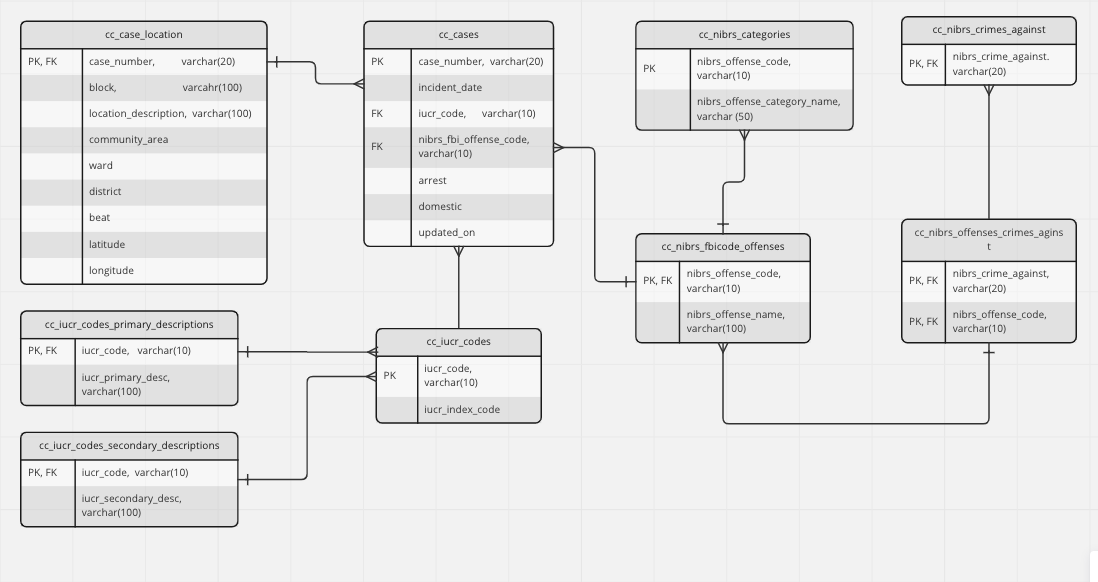

# Perform the ETL of the source data to your SSO dsa_student Chicago Crime Database

* Establish a connection to the the SQLite source database using sqlAlchemy
* Establish a connection to your SSQ dsa_student postgres server destination database using sqlAlchemy
* Peform ETL of the source data tables to the destination data tables incrementally.
  * You may want to consider using pandas as the medium between the two databases 
     * it can easliy read sql table data
     * hold data in a data frame
     * make any necessary transformations to data values
     * write to sql table data
    

In [24]:
# ETL Here
import getpass
mypasswd = getpass.getpass()
username = 'hc3ng'
host = 'pgsql.dsa.lan'
database = 'dsa_student'

from sqlalchemy.engine.url import URL
from sqlalchemy import create_engine

# SQLAlchemy Connection Parameters
postgres_db = {'drivername': 'postgres',
               'username': username,
               'password': mypasswd,
               'host': host,
               'database' :database}
engine = create_engine(URL(**postgres_db), echo=False)


········


In [25]:
del mypasswd


In [26]:
source_engine = create_engine('sqlite:////dsa/data/DSA-7030/cc0122dbv2.sqlite.db')


In [27]:
#1 For cc_iucr_codes

import pandas as pd

read_table = pd.read_sql("SELECT * FROM cc_iucr_codes", source_engine, chunksize=500)

for chunk in read_table:
    chunk.to_sql('cc_iucr_codes', engine,   
    schema=username, 
    index=False,
    if_exists = 'append')


In [28]:
#2 cc_nibrs_crimes_against 

import pandas as pd

read_table = pd.read_sql("SELECT * FROM cc_nibrs_crimes_against", source_engine, chunksize=500)

for chunk in read_table:
    chunk.to_sql('cc_nibrs_crimes_against', engine,   
    schema=username, 
    index=False,
    if_exists = 'append')

In [29]:
#3 cc_nibrs_categories 

import pandas as pd

read_table = pd.read_sql("SELECT * FROM cc_nibrs_categories", source_engine, chunksize=500)

for chunk in read_table:
    chunk.to_sql('cc_nibrs_categories', engine,   
    schema=username, 
    index=False,
    if_exists = 'append')

In [30]:
#4 cc_iucr_codes_primary_descriptions 
import pandas as pd

read_table = pd.read_sql("SELECT * FROM cc_iucr_codes_primary_descriptions", source_engine, chunksize=500)

for chunk in read_table:
    chunk.to_sql('cc_iucr_codes_primary_descriptions', engine,   
    schema=username, 
    index=False,
    if_exists = 'append')


In [31]:
#5 For cc_iucr_codes_secondary_descriptions
import pandas as pd

read_table = pd.read_sql("SELECT * FROM cc_iucr_codes_secondary_descriptions", source_engine, chunksize=500)

for chunk in read_table:
    chunk.to_sql('cc_iucr_codes_secondary_descriptions', engine,   
    schema=username, 
    index=False,
    if_exists = 'append')


In [32]:
#6 cc_nibrs_fbicode_offenses
import pandas as pd

read_table = pd.read_sql("SELECT * FROM cc_nibrs_fbicode_offenses", source_engine, chunksize=500)

for chunk in read_table:
    chunk.to_sql('cc_nibrs_fbicode_offenses', engine,   
    schema=username, 
    index=False,
    if_exists = 'append')


In [33]:
#7 cc_nibrs_offenses_crimes_aginst 

import pandas as pd

read_table = pd.read_sql("SELECT * FROM cc_nibrs_offenses_crimes_aginst", source_engine, chunksize=500)

for chunk in read_table:
    chunk.to_sql('cc_nibrs_offenses_crimes_aginst', engine,   
    schema=username, 
    index=False,
    if_exists = 'append')


In [38]:
#8 cc_cases

import pandas as pd

read_table = pd.read_sql("SELECT * FROM cc_cases", source_engine, chunksize=10000)

for chunk in read_table:
    chunk.to_sql('cc_cases', engine,   
    schema=username, 
    index=False,
    if_exists = 'append')


In [47]:
#9 For cc_case_location table 
import pandas as pd

read_table = pd.read_sql("SELECT * FROM cc_case_location", source_engine, chunksize=1000)

for chunk in read_table:
    chunk.to_sql('cc_case_location', engine,   
    schema=username, 
    index=False,
    if_exists = 'append')


# Execute SQL DML commands to confirm the table record counts for the destination database tables are consistent with the source database table record counts

In [ ]:
# Confirm counts here

## This is the end of Part 1 of the Final Project 
### Part 2 will be deployed in Module 8.

# Save your notebook, then `File > Close and Halt`